In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, classification_report

from plot import plot_two_figures, plot_confusion_matrix, plot_each_labels
from tools import get_number_components, extract_features, remove_unclassified_input, shuffle, split_x_train_test     
from gaussian_naive_bayes import GaussianNaiveBayesClassifier

# Loading data & Pre-processing

Loading Indiana and Salinas images and their ground truth

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
# Reshaping the HSI as a 2D matrix
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1]))
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1]))
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [6]:
n_classes_indiana = len(np.unique(indiana_labels)) - 1
n_classes_salinas = len(np.unique(salinas_labels)) - 1

In [7]:
print("Number of labels Indiana: {}".format(n_classes_indiana))
print("Number of labels Salinas: {}".format(n_classes_salinas))

Number of labels Indiana: 16
Number of labels Salinas: 16


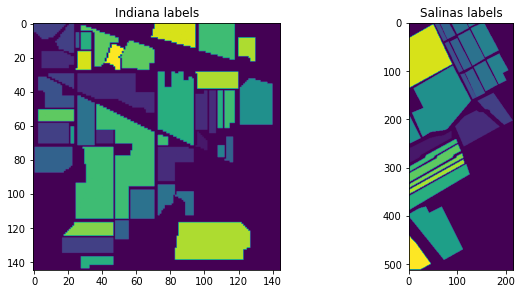

In [8]:
# Display ground truth for each image
plot_two_figures(indiana_labels, salinas_labels, title_fig1='Indiana labels', title_fig2='Salinas labels')

## Remove unclassified data

In [9]:
X_indiana, X_indiana_idx = remove_unclassified_input(X_indiana, indiana_labels)
X_salinas, X_salinas_idx = remove_unclassified_input(X_salinas, salinas_labels)

In [10]:
print(X_indiana.shape)
print(X_indiana_idx.shape)
print(X_salinas.shape)
print(X_salinas_idx.shape)

(10249, 200)
(10249,)
(54129, 204)
(54129,)


In [11]:
indiana_labels_usefull, _ = remove_unclassified_input(indiana_labels.flatten(), indiana_labels)
salinas_labels_usefull, _ = remove_unclassified_input(salinas_labels.flatten(), salinas_labels)

## PCA

PCA stands for principal component analysis. PCA is an unsupervised technique used for reduce the dimensions of the dataset. It transforms the dataset reducing the number of components in order to decrease the computational complexity of the model. 

To reduce the number of component, the PCA computes a linear transformation performing a linear mapping of the data to a lower-dimensional space. It aims to reduce the dimensions with a maximized variance of the data.

In [12]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [13]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 68
Number of components Salinas: 5


After retrieving the optimal number of components for each image, we need to compute a second PCA for each image to extract their features.

In [14]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [15]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (10249, 68)
Salinas reduced data shape: (54129, 5)


## Split train / tests

We will use a supervised learning algorithm. We need to split our dataset into training and testing dataset. To be sure that our splitting is efficient, we decided to manually split data for each label, it is not possible to use train_test_split.
In addition, we decided to shuffle our data so that the split does not return us the first values of each label in the ground truth. 

We are going to use 75% of the data as the training dataset and 25% for the testing.

In [16]:
# shuffle manually
X_indiana_shuffle, indiana_labels_shuffle, shuffle_arr_indiana = shuffle(X_indiana_reduced, indiana_labels_usefull)
X_salinas_shuffle, salinas_labels_shuffle, shuffle_arr_salinas = shuffle(X_salinas_reduced, salinas_labels_usefull)

In [17]:
y_indiana_labels_argsort = np.argsort(indiana_labels_shuffle)
y_salinas_labels_argsort = np.argsort(salinas_labels_shuffle)

In [18]:
labels_indiana, count_indiana = np.unique(indiana_labels_shuffle-1, return_counts=True)
labels_salinas, count_salinas = np.unique(salinas_labels_shuffle-1, return_counts=True)

In [19]:
x_train_indiana, x_test_indiana, y_train_indiana_labels, y_test_indiana_labels = split_x_train_test(X_indiana_shuffle, count_indiana, labels_indiana, y_indiana_labels_argsort, (0, n_components_indiana))

Cluster: 0
Nb total samples: 46
Nb samples train: 34
Nb samples test: 12
---------------
Cluster: 1
Nb total samples: 1428
Nb samples train: 1071
Nb samples test: 357
---------------
Cluster: 2
Nb total samples: 830
Nb samples train: 622
Nb samples test: 208
---------------
Cluster: 3
Nb total samples: 237
Nb samples train: 177
Nb samples test: 60
---------------
Cluster: 4
Nb total samples: 483
Nb samples train: 362
Nb samples test: 121
---------------
Cluster: 5
Nb total samples: 730
Nb samples train: 547
Nb samples test: 183
---------------
Cluster: 6
Nb total samples: 28
Nb samples train: 21
Nb samples test: 7
---------------
Cluster: 7
Nb total samples: 478
Nb samples train: 358
Nb samples test: 120
---------------
Cluster: 8
Nb total samples: 20
Nb samples train: 15
Nb samples test: 5
---------------
Cluster: 9
Nb total samples: 972
Nb samples train: 729
Nb samples test: 243
---------------
Cluster: 10
Nb total samples: 2455
Nb samples train: 1841
Nb samples test: 614
-----------

In [20]:
x_train_salinas, x_test_salinas, y_train_salinas_labels, y_test_salinas_labels = split_x_train_test(X_salinas_shuffle, count_salinas, labels_salinas, y_salinas_labels_argsort, (0, n_components_salinas))

Cluster: 0
Nb total samples: 2009
Nb samples train: 1506
Nb samples test: 503
---------------
Cluster: 1
Nb total samples: 3726
Nb samples train: 2794
Nb samples test: 932
---------------
Cluster: 2
Nb total samples: 1976
Nb samples train: 1482
Nb samples test: 494
---------------
Cluster: 3
Nb total samples: 1394
Nb samples train: 1045
Nb samples test: 349
---------------
Cluster: 4
Nb total samples: 2678
Nb samples train: 2008
Nb samples test: 670
---------------
Cluster: 5
Nb total samples: 3959
Nb samples train: 2969
Nb samples test: 990
---------------
Cluster: 6
Nb total samples: 3579
Nb samples train: 2684
Nb samples test: 895
---------------
Cluster: 7
Nb total samples: 11271
Nb samples train: 8453
Nb samples test: 2818
---------------
Cluster: 8
Nb total samples: 6203
Nb samples train: 4652
Nb samples test: 1551
---------------
Cluster: 9
Nb total samples: 3278
Nb samples train: 2458
Nb samples test: 820
---------------
Cluster: 10
Nb total samples: 1068
Nb samples train: 801


In [21]:
print("Indiana")
print("Train shape: {}".format(x_train_indiana.shape))
print("Train labels shape: {}".format(y_train_indiana_labels.shape))
print("Test shape: {}".format(x_test_indiana.shape))
print("Test labels shape: {}".format(y_test_indiana_labels.shape))
print("----------")
print("Indiana")
print("Train shape: {}".format(x_train_salinas.shape))
print("Train labels shape: {}".format(y_train_salinas_labels.shape))
print("Test shape: {}".format(x_test_salinas.shape))
print("Test labels shape: {}".format(y_test_salinas_labels.shape))

Indiana
Train shape: (7680, 68)
Train labels shape: (7680,)
Test shape: (2569, 68)
Test labels shape: (2569,)
----------
Indiana
Train shape: (40592, 5)
Train labels shape: (40592,)
Test shape: (13537, 5)
Test labels shape: (13537,)


## Supervised model

Gaussian Naive Bayes Classifier is a supervised generative model.
The idea is to fit a number of gaussian in a supervised way in the dataset.
In this notebook the covariance matrix for each gaussian is the identity matrix.

In [22]:
nb_classes = np.unique(y_train_indiana_labels).size

In [23]:
n_features_indiana = x_train_indiana.shape[-1]
n_features_salinas = x_train_salinas.shape[-1]

indiana_model_naive_bayes = GaussianNaiveBayesClassifier(nb_gaussian=nb_classes, n_features=n_features_indiana)
salinas_model_naive_bayes = GaussianNaiveBayesClassifier(nb_gaussian=nb_classes, n_features=n_features_salinas)

In [24]:
indiana_model_naive_bayes.fit(x_train_indiana, y_train_indiana_labels)

Fit Gaussian nb. 0
Fit Gaussian nb. 1
Fit Gaussian nb. 2
Fit Gaussian nb. 3
Fit Gaussian nb. 4
Fit Gaussian nb. 5
Fit Gaussian nb. 6
Fit Gaussian nb. 7
Fit Gaussian nb. 8
Fit Gaussian nb. 9
Fit Gaussian nb. 10
Fit Gaussian nb. 11
Fit Gaussian nb. 12
Fit Gaussian nb. 13
Fit Gaussian nb. 14
Fit Gaussian nb. 15


In [25]:
salinas_model_naive_bayes.fit(x_train_salinas, y_train_salinas_labels)

Fit Gaussian nb. 0
Fit Gaussian nb. 1
Fit Gaussian nb. 2
Fit Gaussian nb. 3
Fit Gaussian nb. 4
Fit Gaussian nb. 5
Fit Gaussian nb. 6
Fit Gaussian nb. 7
Fit Gaussian nb. 8
Fit Gaussian nb. 9
Fit Gaussian nb. 10
Fit Gaussian nb. 11
Fit Gaussian nb. 12
Fit Gaussian nb. 13
Fit Gaussian nb. 14
Fit Gaussian nb. 15


#### Test the indiana model on training and testing data

In [26]:
%%time
train_acc = []
for label in labels_indiana:
    idxs = np.argwhere(y_train_indiana_labels == label).flatten()
    preds = indiana_model_naive_bayes.predict(x_train_indiana[idxs])
    acc = indiana_model_naive_bayes.measure_accuracy(preds, y_train_indiana_labels[idxs])
    train_acc.append(acc)
    print("Class: {}".format(label))
    print("Nb samples: {}".format(y_train_indiana_labels[idxs].size))
    print("Score: {}".format(acc))
    print("-----------")
    
indiana_training_score = np.array(train_acc).mean()
print("Mean accuracy per class: {}".format(indiana_training_score))

Class: 0
Nb samples: 34
Score: 0.9117647058823529
-----------
Class: 1
Nb samples: 1071
Score: 0.5434173669467787
-----------
Class: 2
Nb samples: 622
Score: 0.1832797427652733
-----------
Class: 3
Nb samples: 177
Score: 0.1751412429378531
-----------
Class: 4
Nb samples: 362
Score: 0.04143646408839779
-----------
Class: 5
Nb samples: 547
Score: 0.4040219378427788
-----------
Class: 6
Nb samples: 21
Score: 0.9047619047619048
-----------
Class: 7
Nb samples: 358
Score: 0.7318435754189944
-----------
Class: 8
Nb samples: 15
Score: 0.8
-----------
Class: 9
Nb samples: 729
Score: 0.45816186556927296
-----------
Class: 10
Nb samples: 1841
Score: 0.2275936990765888
-----------
Class: 11
Nb samples: 444
Score: 0.09009009009009009
-----------
Class: 12
Nb samples: 153
Score: 0.9281045751633987
-----------
Class: 13
Nb samples: 948
Score: 0.8375527426160337
-----------
Class: 14
Nb samples: 289
Score: 0.2491349480968858
-----------
Class: 15
Nb samples: 69
Score: 0.9710144927536232
-----------


In [27]:
%%time
test_acc = []

for label in labels_indiana:
    idxs = np.argwhere(y_test_indiana_labels == label).flatten()
    preds = indiana_model_naive_bayes.predict(x_test_indiana[idxs])
    acc = indiana_model_naive_bayes.measure_accuracy(preds, y_test_indiana_labels[idxs])
    test_acc.append(acc)
    print("Class: {}".format(label))
    print("Nb samples: {}".format(y_test_indiana_labels[idxs].size))
    print("Score: {}".format(acc))
    print("-----------")
    
indiana_testing_score = np.array(test_acc).mean()
print("Mean accuracy per class: {}".format(indiana_testing_score))

Class: 0
Nb samples: 12
Score: 0.9166666666666666
-----------
Class: 1
Nb samples: 357
Score: 0.4957983193277311
-----------
Class: 2
Nb samples: 208
Score: 0.11538461538461539
-----------
Class: 3
Nb samples: 60
Score: 0.11666666666666667
-----------
Class: 4
Nb samples: 121
Score: 0.01652892561983471
-----------
Class: 5
Nb samples: 183
Score: 0.37158469945355194
-----------
Class: 6
Nb samples: 7
Score: 1.0
-----------
Class: 7
Nb samples: 120
Score: 0.7416666666666667
-----------
Class: 8
Nb samples: 5
Score: 1.0
-----------
Class: 9
Nb samples: 243
Score: 0.46502057613168724
-----------
Class: 10
Nb samples: 614
Score: 0.250814332247557
-----------
Class: 11
Nb samples: 149
Score: 0.1342281879194631
-----------
Class: 12
Nb samples: 52
Score: 0.9423076923076923
-----------
Class: 13
Nb samples: 317
Score: 0.8201892744479495
-----------
Class: 14
Nb samples: 97
Score: 0.24742268041237114
-----------
Class: 15
Nb samples: 24
Score: 0.9583333333333334
-----------
Mean accuracy per cl

#### Test the salinas model on training and testing data

In [28]:
%%time
train_acc = []
for label in labels_salinas:
    idxs = np.argwhere(y_train_salinas_labels == label).flatten()
    preds = salinas_model_naive_bayes.predict(x_train_salinas[idxs])
    acc = salinas_model_naive_bayes.measure_accuracy(preds, y_train_salinas_labels[idxs])
    train_acc.append(acc)
    print("Class: {}".format(label))
    print("Nb samples: {}".format(y_train_salinas_labels[idxs].size))
    print("Score: {}".format(acc))
    print("-----------")
    
salinas_training_score = np.array(train_acc).mean()
print("Mean accuracy per class: {}".format(salinas_training_score))

Class: 0
Nb samples: 1506
Score: 0.9820717131474104
-----------
Class: 1
Nb samples: 2794
Score: 0.7913385826771654
-----------
Class: 2
Nb samples: 1482
Score: 0.7456140350877193
-----------
Class: 3
Nb samples: 1045
Score: 0.9875598086124402
-----------
Class: 4
Nb samples: 2008
Score: 0.953187250996016
-----------
Class: 5
Nb samples: 2969
Score: 0.9666554395419333
-----------
Class: 6
Nb samples: 2684
Score: 0.9873323397913562
-----------
Class: 7
Nb samples: 8453
Score: 0.6099609606057022
-----------
Class: 8
Nb samples: 4652
Score: 0.8927343078245916
-----------
Class: 9
Nb samples: 2458
Score: 0.24654190398698128
-----------
Class: 10
Nb samples: 801
Score: 0.7940074906367042
-----------
Class: 11
Nb samples: 1445
Score: 0.8961937716262975
-----------
Class: 12
Nb samples: 687
Score: 0.9883551673944687
-----------
Class: 13
Nb samples: 802
Score: 0.8890274314214464
-----------
Class: 14
Nb samples: 5451
Score: 0.6123647037240874
-----------
Class: 15
Nb samples: 1355
Score: 0.51

In [29]:
%%time
test_acc = []
for label in labels_salinas:
    idxs = np.argwhere(y_test_salinas_labels == label).flatten()
    preds = salinas_model_naive_bayes.predict(x_test_salinas[idxs])
    acc = salinas_model_naive_bayes.measure_accuracy(preds, y_test_salinas_labels[idxs])
    test_acc.append(acc)
    print("Class: {}".format(label))
    print("Nb samples: {}".format(y_test_salinas_labels[idxs].size))
    print("Score: {}".format(acc))
    print("-----------")
    
salinas_testing_score = np.array(test_acc).mean()
print("Mean accuracy per class: {}".format(salinas_testing_score))

Class: 0
Nb samples: 503
Score: 0.9880715705765407
-----------
Class: 1
Nb samples: 932
Score: 0.7950643776824035
-----------
Class: 2
Nb samples: 494
Score: 0.7591093117408907
-----------
Class: 3
Nb samples: 349
Score: 0.9885386819484241
-----------
Class: 4
Nb samples: 670
Score: 0.9507462686567164
-----------
Class: 5
Nb samples: 990
Score: 0.9676767676767677
-----------
Class: 6
Nb samples: 895
Score: 0.9854748603351955
-----------
Class: 7
Nb samples: 2818
Score: 0.6043293115684882
-----------
Class: 8
Nb samples: 1551
Score: 0.8987749838813669
-----------
Class: 9
Nb samples: 820
Score: 0.21951219512195122
-----------
Class: 10
Nb samples: 267
Score: 0.8202247191011236
-----------
Class: 11
Nb samples: 482
Score: 0.8941908713692946
-----------
Class: 12
Nb samples: 229
Score: 0.9781659388646288
-----------
Class: 13
Nb samples: 268
Score: 0.8917910447761194
-----------
Class: 14
Nb samples: 1817
Score: 0.593285635663181
-----------
Class: 15
Nb samples: 452
Score: 0.557522123893

#### Classification report for Indiana model

In [30]:
%%time
total_preds_indiana = indiana_model_naive_bayes.predict(x_test_indiana)

CPU times: user 46.4 s, sys: 1min 41s, total: 2min 27s
Wall time: 18.7 s


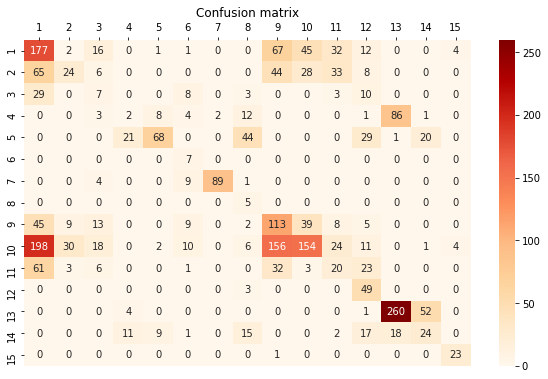

In [31]:
plot_confusion_matrix(y_test_indiana_labels, total_preds_indiana, class_names=np.arange(1, 16), log=False)

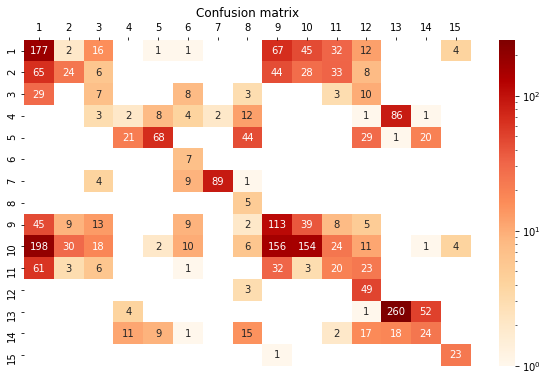

In [32]:
plot_confusion_matrix(y_test_indiana_labels, total_preds_indiana, class_names=np.arange(1, 16), log=True)

On the confusion matrix, we can see that classify data with label 10 seems difficult to our model. There is a third of the data with label 10 which is classified as label 1 data.

In [33]:
indiana_class_names = np.arange(n_classes_indiana).astype(str)

In [34]:
print(classification_report(y_test_indiana_labels, total_preds_indiana, target_names=indiana_class_names))

              precision    recall  f1-score   support

           0       0.37      0.92      0.52        12
           1       0.31      0.50      0.38       357
           2       0.35      0.12      0.17       208
           3       0.10      0.12      0.11        60
           4       0.05      0.02      0.03       121
           5       0.77      0.37      0.50       183
           6       0.14      1.00      0.25         7
           7       0.97      0.74      0.84       120
           8       0.05      1.00      0.10         5
           9       0.27      0.47      0.34       243
          10       0.57      0.25      0.35       614
          11       0.16      0.13      0.15       149
          12       0.30      0.94      0.45        52
          13       0.71      0.82      0.76       317
          14       0.24      0.25      0.25        97
          15       0.74      0.96      0.84        24

    accuracy                           0.40      2569
   macro avg       0.38   

Gaussian Naive Bayes classifier does not look good enough to compute classification on Indiana image. The mean accuracy is only around 0.50. Using the classification report, we can notice that the efficiency of our model is not based on the number of samples per class. For instance, the label 10 contains more than 600 samples but f1-score is only 0.33 whereas label 13 contains 300 samples and its f1-score is 0.80

#### Classification report for Salinas model

In [35]:
%%time
total_preds_salinas = salinas_model_naive_bayes.predict(x_test_salinas)

CPU times: user 11.3 s, sys: 39.8 ms, total: 11.3 s
Wall time: 11.3 s


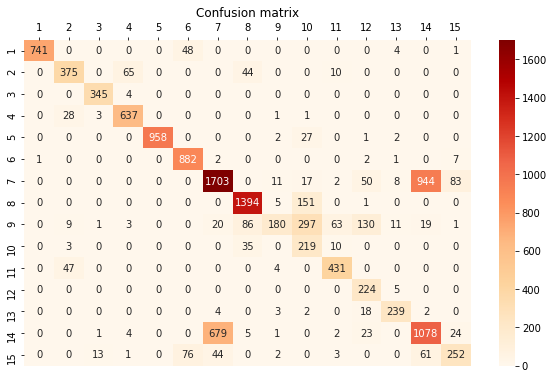

In [36]:
plot_confusion_matrix(y_test_salinas_labels, total_preds_salinas, class_names=np.arange(1, 16), log=False)

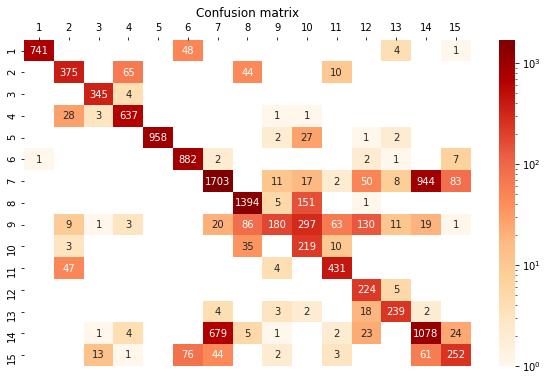

In [37]:
plot_confusion_matrix(y_test_salinas_labels, total_preds_salinas, class_names=np.arange(1, 16), log=True)

On the confusion matrix, we can easily distinguish the diagonal of the matrix and therefore our model may look efficient in this image. However, we can also see some pretty big errors, especially for classes 7 and 14.

In [38]:
salinas_class_names = np.arange(n_classes_salinas).astype(str)

In [39]:
print(classification_report(y_test_salinas_labels, total_preds_salinas, target_names=salinas_class_names))

              precision    recall  f1-score   support

           0       0.78      0.99      0.87       503
           1       0.99      0.80      0.88       932
           2       0.81      0.76      0.78       494
           3       0.95      0.99      0.97       349
           4       0.89      0.95      0.92       670
           5       1.00      0.97      0.98       990
           6       0.88      0.99      0.93       895
           7       0.69      0.60      0.65      2818
           8       0.89      0.90      0.90      1551
           9       0.86      0.22      0.35       820
          10       0.31      0.82      0.45       267
          11       0.83      0.89      0.86       482
          12       0.50      0.98      0.66       229
          13       0.89      0.89      0.89       268
          14       0.51      0.59      0.55      1817
          15       0.68      0.56      0.61       452

    accuracy                           0.75     13537
   macro avg       0.78   

Even if there is a few labels with a f1-score lower than 0.50, we can consider that having a accuracy upper than 0.70 is good enough to perform classifications.

### Prediction on images

#### Indiana image

In [40]:
%%time
total_preds_indiana = indiana_model_naive_bayes.predict(X_indiana_reduced)

CPU times: user 3min 29s, sys: 8min 28s, total: 11min 58s
Wall time: 1min 33s


In [41]:
indiana_preds_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
indiana_preds_img[X_indiana_idx] = total_preds_indiana + 1
indiana_preds_img = indiana_preds_img.reshape(((indiana_img.shape[0], indiana_img.shape[1])))

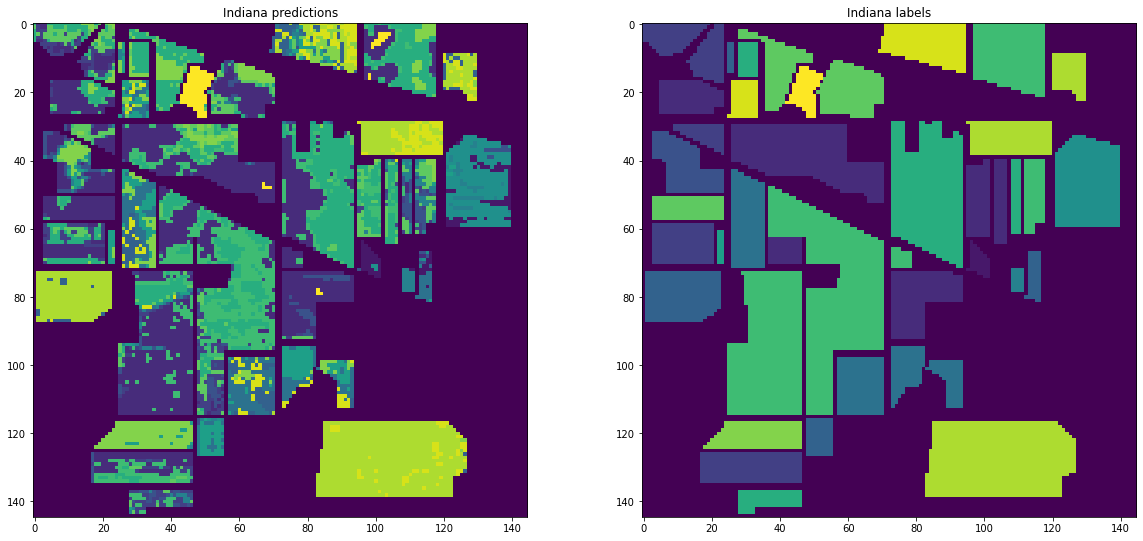

In [42]:
plot_two_figures(indiana_preds_img, indiana_labels, 'Indiana predictions', 'Indiana labels', figsize=(20, 20))

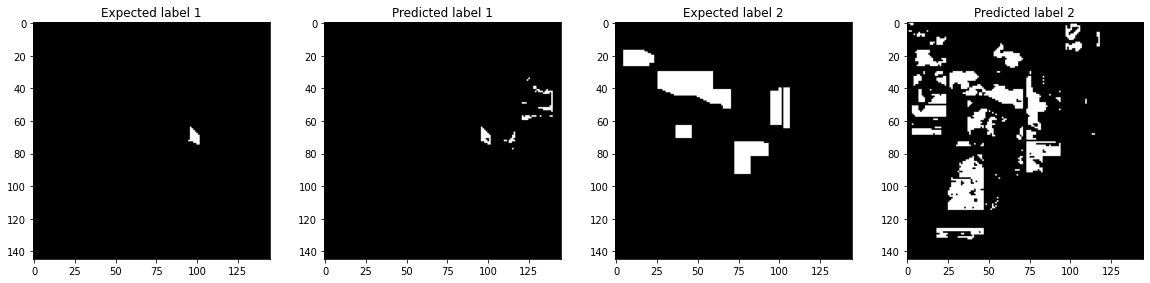

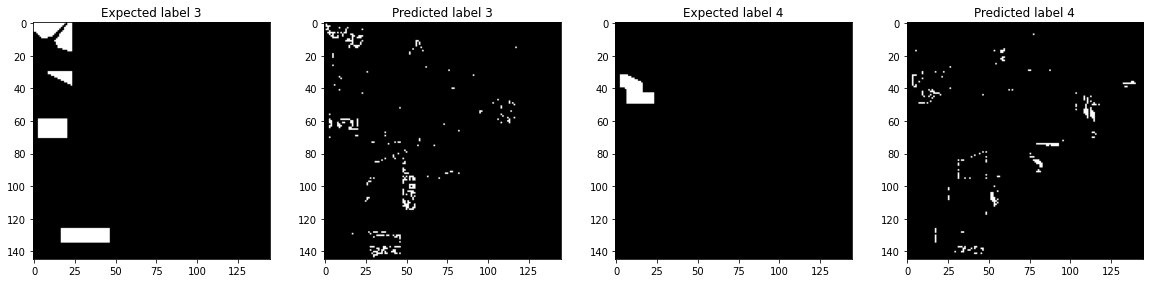

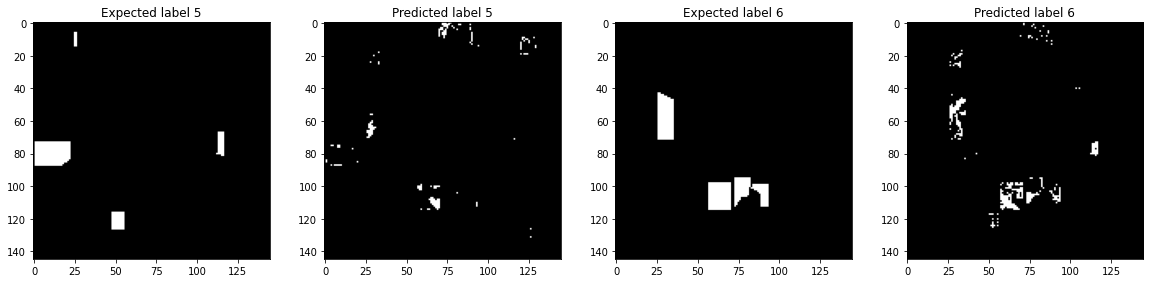

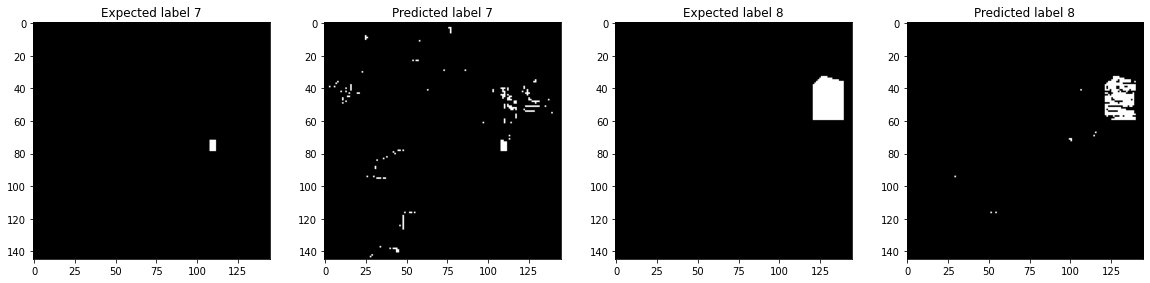

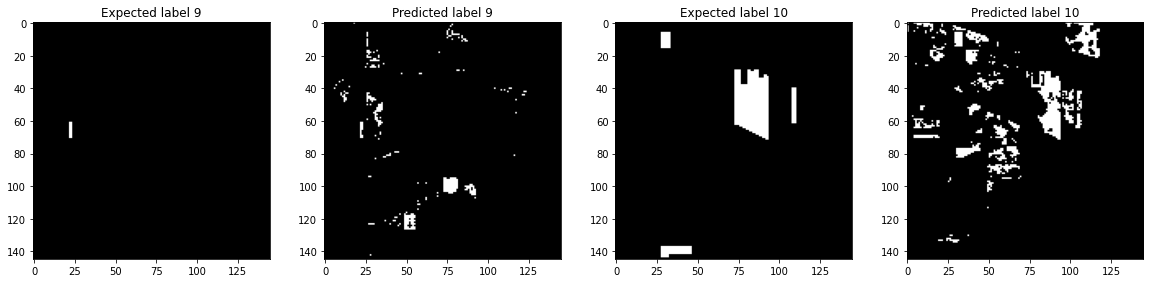

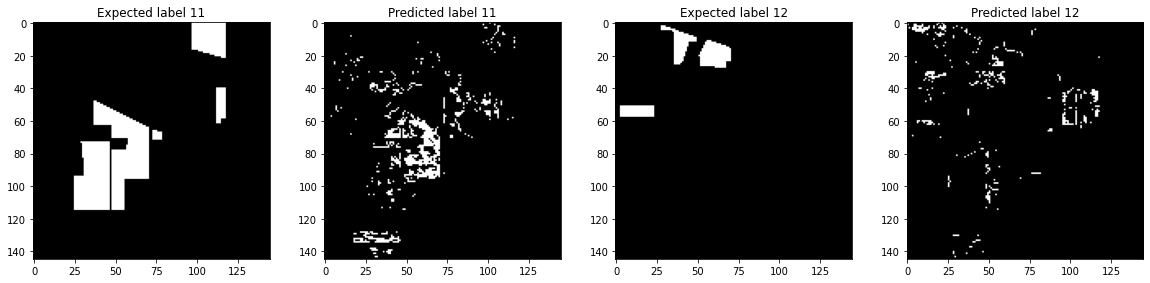

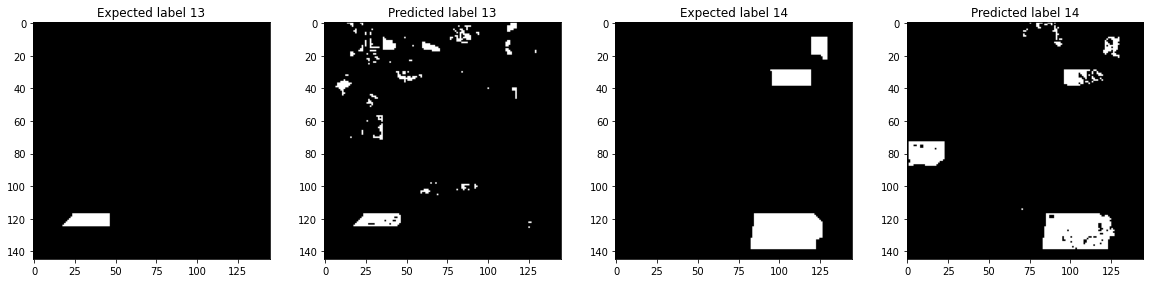

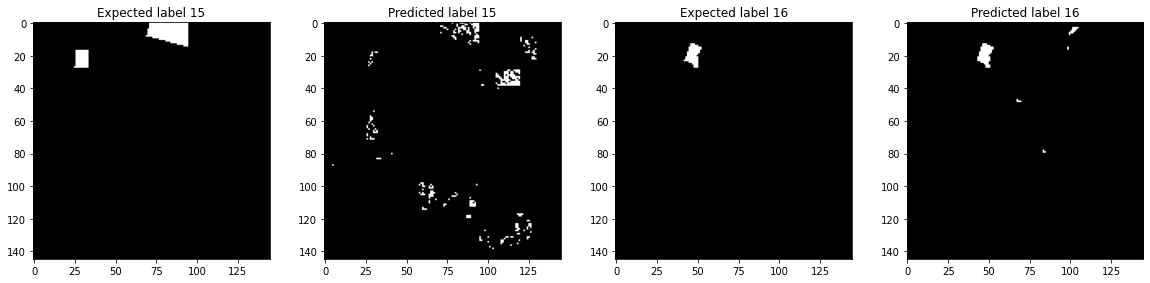

In [43]:
plot_each_labels(indiana_labels, indiana_preds_img, n_classes_indiana, figsize=(20, 20), cmap='gray')

On indiana image, the model had a accuracy of 0.41. When we look at each label, we can notice that some classes have been correctly identified while others are not at all. In addition, there is a lot of noise on each label.

#### Salinas image

In [44]:
%%time
total_preds_salinas = salinas_model_naive_bayes.predict(X_salinas_reduced)

CPU times: user 44 s, sys: 123 ms, total: 44.1 s
Wall time: 44.1 s


In [45]:
salinas_preds_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))
salinas_preds_img[X_salinas_idx] = total_preds_salinas + 1
salinas_preds_img = salinas_preds_img.reshape(((salinas_img.shape[0], salinas_img.shape[1])))

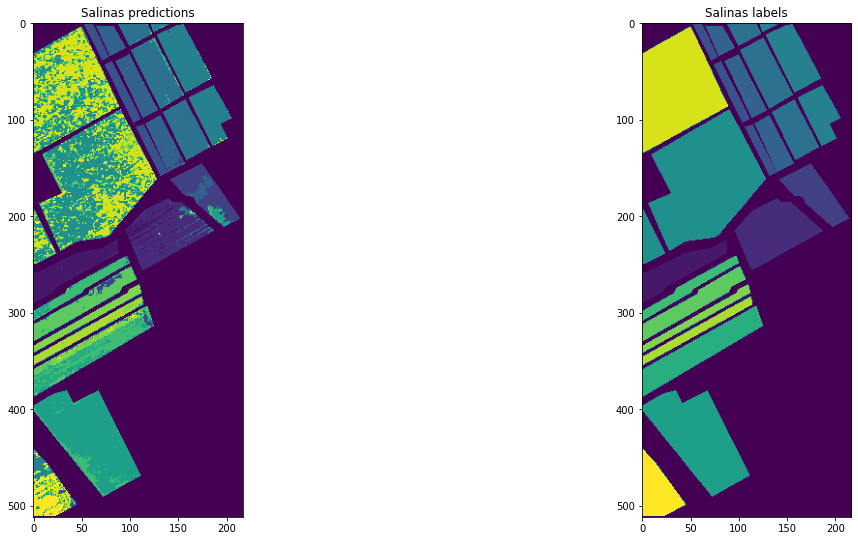

In [46]:
plot_two_figures(salinas_preds_img, salinas_labels, 'Salinas predictions', 'Salinas labels', figsize=(20, 20))

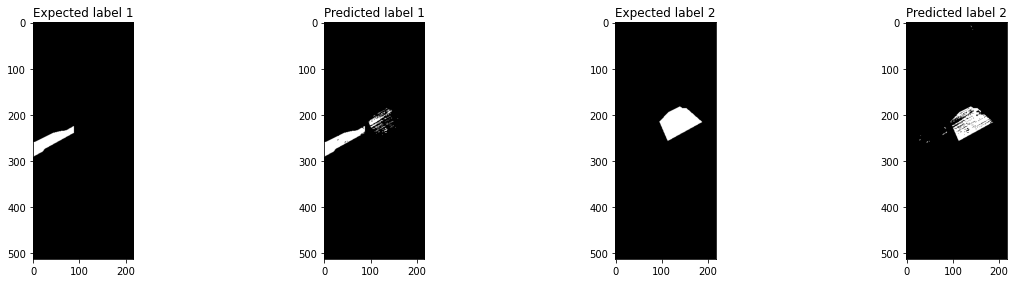

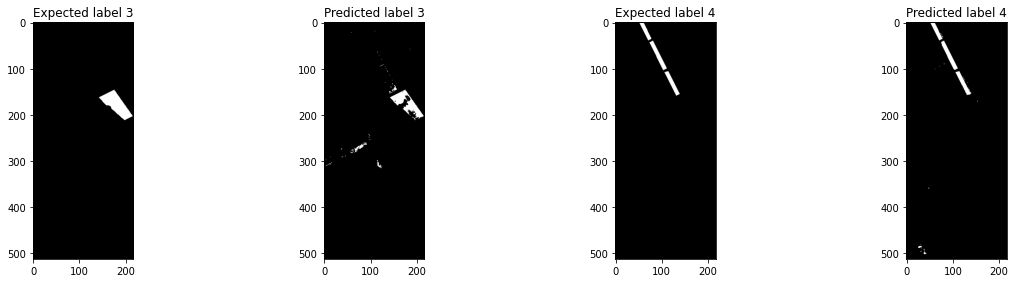

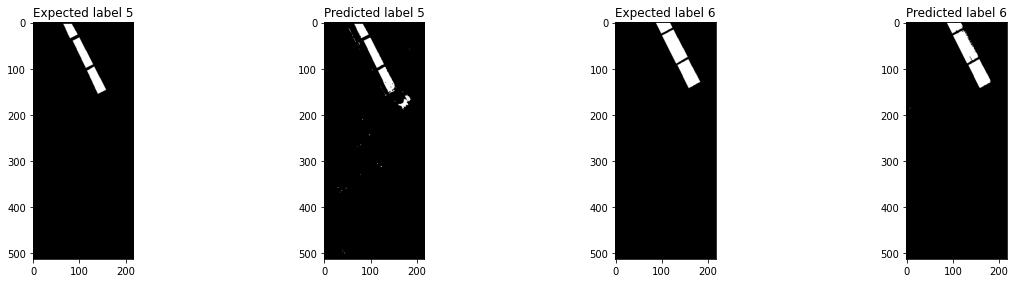

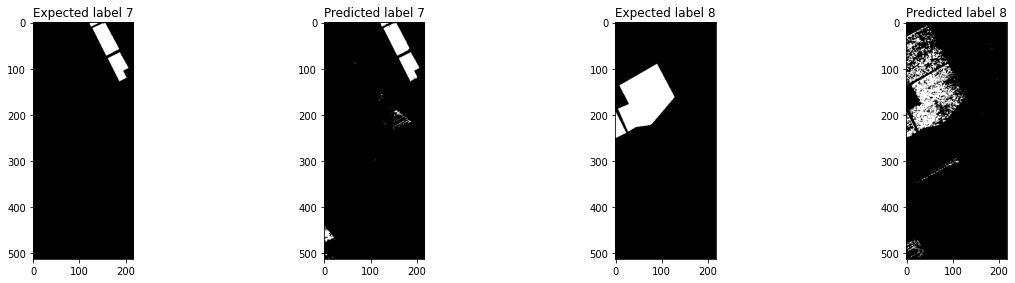

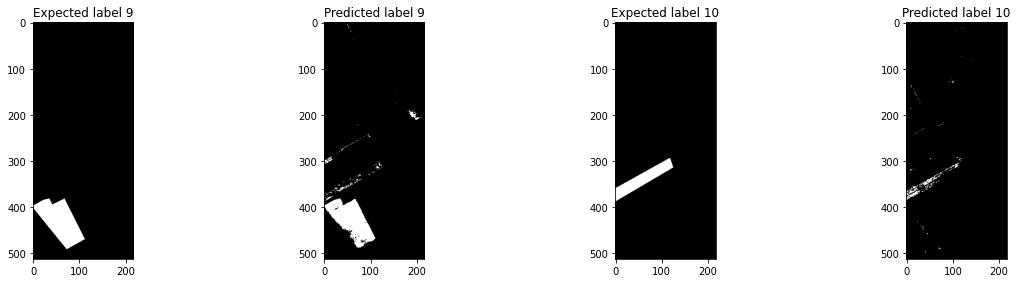

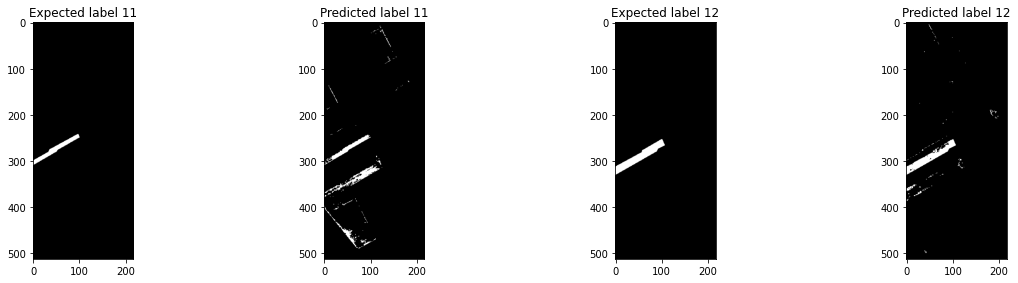

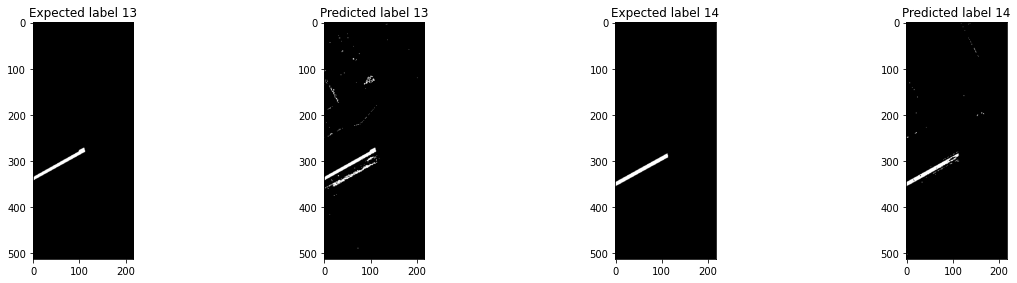

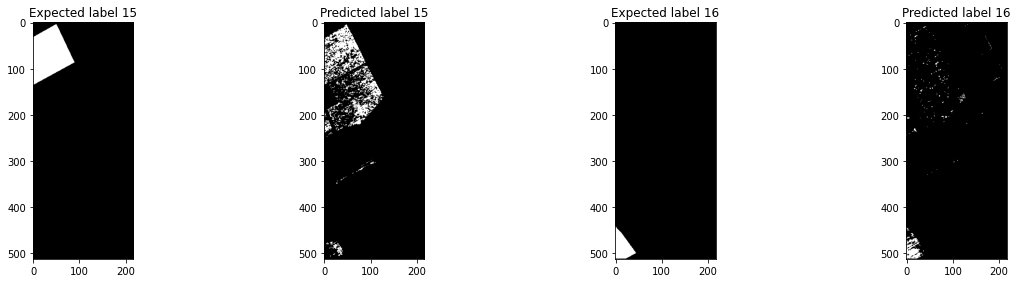

In [47]:
plot_each_labels(salinas_labels, salinas_preds_img, n_classes_salinas, figsize=(20, 20), cmap='gray')

On salinas image, the classification of each label seems appropriate. We can notice that for the labels 8 and 15, there is a lot of noise (those labels are labels 7 and 14 during the training / testing).

## Save predictions

In order to be able to compare models , we save our prediction data on each image. We also save model's score.

In [48]:
np.save('../data/predictions/indiana_preds_gaussianNaiveBayes.npy', indiana_preds_img)
np.save('../data/predictions/salinas_preds_gaussianNaiveBayes.npy', salinas_preds_img)

In [49]:
# Check if csv file exists
try:
    df = pd.read_csv('../data/score.csv')
except Exception:
    cols = ['model', 'image', 'score_test', 'score_train']
    df = pd.DataFrame(columns=cols)

In [50]:
df.loc[df.size] = ['GaussianNaiveBayes', 'indiana', indiana_testing_score, indiana_training_score]
df.loc[df.size] = ['GaussianNaiveBayes', 'salinas', salinas_testing_score, salinas_training_score]

In [51]:
df.to_csv('../data/score.csv', index=False)